In [1]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from model import ExpressionSqueezeNet, ExpressionMobileNet
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
from random import choice
import torchvision
import numpy as np

In [2]:
def imshow(img,text=None,should_save=False):
    npimg = torchvision.utils.make_grid(img).numpy()
    plt.axis("off")
    if text:
        text1, text2 = text
        plt.text(110, 18, text1, fontweight='bold', horizontalalignment='center',
            bbox=dict(facecolor='white'))
        plt.text(340, 18, text2, fontweight='bold', horizontalalignment='center',
            bbox=dict(facecolor='white'))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [3]:
train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([
    lambda x: x.convert('RGB'),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])
topil = transforms.ToPILImage()
totensor = transforms.Compose(valid_transforms.transforms[:-1])

def k_rgb(img):
    red = img[:,:,:,0]
    blue = img[:,:,:,2]
    green = img[:,:,:,1]
    return red, green, blue

def keras_val_transform(img):
    r_,g_,b_ = k_rgb(kimg)
    R_ = (r_ - 0.485) / 0.229
    G_ = (g_ - 0.456) / 0.224
    B_ = (b_ - 0.406) / 0.225
    knorm = np.concatenate((R_,G_,B_))
    knorm = np.transpose(knorm, (1,2,0))
    return np.expand_dims(knorm,0)

In [4]:
test_set = list(Path('/Users/khairulimam/workspaces/DeepLearning/projects/imfdb/tensorflow').glob('*.jpg'))

In [5]:
classes = ['ANGER', 'DISGUST', 'FEAR', 'HAPPINESS', 'NEUTRAL', 'SADNESS', 'SURPRISE']

In [6]:
def predict(model, img):
    x = valid_transforms(img).to(device)
    model.eval()
    with torch.no_grad():
        logits = model(x.unsqueeze(0))
        _, p = torch.max(logits, 1)
        return classes[p], p, logits

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model1 = ExpressionSqueezeNet()
model2 = ExpressionMobileNet()
model3 = ExpressionSqueezeNet()
model4 = ExpressionMobileNet()
model5 = ExpressionMobileNet()

In [8]:
state1 = torch.load('squeezenet.pth', map_location='cpu')
state2 = torch.load('mobilenet.pth', map_location='cpu')
state3 = torch.load('../../models/imfdb-squeezenet-sgd.pth', map_location='cpu')
state4 = torch.load('../../models/model-adam.pth', map_location='cpu')
state5 = torch.load('../../models/model-sgd.pth', map_location='cpu')
model1.load_state_dict(state1['state'])
model2.load_state_dict(state2['state'])
model3.load_state_dict(state3['state'])
model4.load_state_dict(state4['state'])
model5.load_state_dict(state5['state'])

<All keys matched successfully>

In [9]:
model1.to(device)
model2.to(device)
pass

In [10]:
totensor(Image.open(choice(test_set)))

IndexError: Cannot choose from an empty sequence

In [11]:
img = Image.open(choice(test_set))
x = totensor(img).unsqueeze(0)
model1_predict, p1, logit1 = predict(model1, img)
model3_predict, p2, logit2 = predict(model3, img)
plt.subplots(1,1)
imshow(torch.cat((x,x),0), (f'Squeezenet1 - {model1_predict}', f'Squeezenet2 - {model3_predict}'))
model4_predict, p1, logit1 = predict(model4, img)
model5_predict, p2, logit2 = predict(model5, img)
plt.subplots(1,1)
imshow(torch.cat((x,x),0), (f'Mobilenet adam - {model4_predict}', f'Mobilenet sgd - {model5_predict}'))

IndexError: Cannot choose from an empty sequence

In [12]:
logit1, logit2

NameError: name 'logit1' is not defined

In [13]:
torch.sum(logit1)

NameError: name 'logit1' is not defined

In [14]:
torch.save(model5.state_dict(), 'mobilenet-sgd.pth')

# KERAS MODEL

In [287]:
import keras
from keras import backend as K
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
import numpy as np
from keras.optimizers import Adam
from datetime import datetime
from tensorflow import lite

In [283]:
from keras.applications.mobilenet_v2 import MobileNetV2

base_model1 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x=base_model1.output
x=GlobalAveragePooling2D()(x)
preds=Dense(7,activation='softmax')(x)
kmodel1 = Model(inputs=base_model1.input,outputs=preds)
kmodel1.load_weights('keras-mobile-expression.h5')

In [318]:
def load_image(img_path, show=False):
    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

def pred(img, model_):
    imgage = valid_transforms(Image.open(img)).permute(1,2,0).unsqueeze(0).numpy()
    prediction = model_.predict(imgage)
    max_ = np.argmax(prediction)
    return max_, prediction.flatten()[max_]

Keras model: ANGER 0.4174877
Squeezenet1: DISGUST
Squeezenet2: DISGUST
Mobile Adam: NEUTRAL
Mobile SGD: NEUTRAL


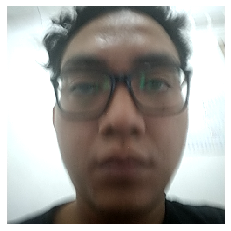

In [439]:
i = choice(test_set)
img = Image.open(i)
x = totensor(img).unsqueeze(0)
model1_predict, p1, logit1 = predict(model1, img)
model3_predict, p2, logit2 = predict(model3, img)
# plt.subplots(1,1)
# imshow(torch.cat((x,x),0), (f'Squeezenet1 - {model1_predict}', f'Squeezenet2 - {model3_predict}'))
model4_predict, p1, logit1 = predict(model4, img)
model5_predict, p2, logit2 = predict(model5, img)
# plt.subplots(1,1)
# imshow(torch.cat((x,x),0), (f'Mobilenet adam - {model4_predict}', f'Mobilenet sgd - {model5_predict}'))
keras_pred, score = pred(i, kmodel1)
plt.imshow(x.squeeze().permute(1,2,0))
plt.axis('off')
print("Keras model:", classes[keras_pred], score)
print("Squeezenet1:", model1_predict)
print("Squeezenet2:", model3_predict)
print("Mobile Adam:", model4_predict)
print("Mobile SGD:", model5_predict)